<a href="https://colab.research.google.com/github/shrimasidda/Obesity-Risk-Prediction/blob/main/Final_External.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier

path_train = '/content/sample_data/train.csv'
path_test = '/content/sample_data/test.csv'

data_train = pd.read_csv(path_train)
data_test = pd.read_csv(path_test)

data_train.shape
df = pd.DataFrame(data_train)
missing_val_train = df.isnull().sum()

print("Missing values in data :")
print(missing_val_train[missing_val_train > 0])
df_test = pd.DataFrame(data_test)
missing_val_test = df_test.isnull().sum()

print("Missing values in data :")
print(missing_val_test[missing_val_test > 0])
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Missing values in data :
Series([], dtype: int64)
Missing values in data :
Series([], dtype: int64)
Numerical Columns: Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')
Categorical Columns: Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')


In [ ]:


# Get the mean of all numeric columns (features)
means = df.mean(numeric_only=True)

print(means)


id        10378.500000
Age          23.841804
Height        1.700245
Weight       87.887768
FCVC          2.445908
NCP           2.761332
CH2O          2.029418
FAF           0.981747
TUE           0.616756
dtype: float64


In [ ]:
for column in categorical_cols:
    print(f"Unique values in '{column}': {df[column].unique()}")


Unique values in 'Gender': ['Male' 'Female']
Unique values in 'family_history_with_overweight': ['yes' 'no']
Unique values in 'FAVC': ['yes' 'no']
Unique values in 'CAEC': ['Sometimes' 'Frequently' 'no' 'Always']
Unique values in 'SMOKE': ['no' 'yes']
Unique values in 'SCC': ['no' 'yes']
Unique values in 'CALC': ['Sometimes' 'no' 'Frequently']
Unique values in 'MTRANS': ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
Unique values in 'NObeyesdad': ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


In [ ]:
print('Number of rows and columns:\n')
data_train.shape

Number of rows and columns:



(20758, 18)

In [ ]:
print("size of dataframe:",data_train.size)
data_train.dtypes


size of dataframe: 373644


,0
id,int64
Gender,object
Age,float64
Height,float64
Weight,float64
family_history_with_overweight,object
FAVC,object
FCVC,float64
NCP,float64
CAEC,object


In [ ]:
test = pd.read_csv(path_test)

test_sub=test.copy()
def convert_column_datatype(df, column_name):
 """
 Convert the data type of a specified column in the dataframe to
integer.

 Parameters:
 df (DataFrame): The dataframe containing the column to be
converted.
 column_name (str): The name of the column to be converted.

 Returns:
 DataFrame: The dataframe with the specified column converted to
integer data type.
 """
 df[column_name] = df[column_name].astype('int32')
 return df
data_train = convert_column_datatype(data_train, 'Age')
data_train = convert_column_datatype(data_train, 'Weight')
# Example usage:
test_sub = convert_column_datatype(test_sub, 'Age')
test_sub = convert_column_datatype(test_sub, 'Weight')


In [ ]:
new_column_names = {
 'Gender': 'Gender',
 'Age': 'Age',
 'Height': 'Height',
 'Weight': 'Weight',
 'family_history_with_overweight': 'Overweighted Family History',
 'FAVC': 'High caleric food consp',
 'FCVC': 'veg consp',
 'NCP': 'main meal consp',
 'CAEC': 'Food btw meal consp',
 'SMOKE': 'SMOKE',
 'CH2O': 'Water consp',
 'SCC': 'Calories Monitoring',
 'FAF': 'physical actv',
 'TUE': 'Screentime',
 'CALC': 'Alcohol consp',
 'MTRANS': 'transport used',
 'NObeyesdad': 'Obesity_Level'
}
# Rename the columns for train data
data_train.rename(columns=new_column_names, inplace=True)
data_train.head(5)


,id,Gender,Age,Height,Weight,Overweighted Family History,High caleric food consp,veg consp,main meal consp,Food btw meal consp,SMOKE,Water consp,Calories Monitoring,physical actv,Screentime,Alcohol consp,transport used,Obesity_Level
0,0,Male,24,1.699998,81,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18,1.560000,57,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18,1.711460,50,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20,1.710730,131,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31,1.914186,93,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


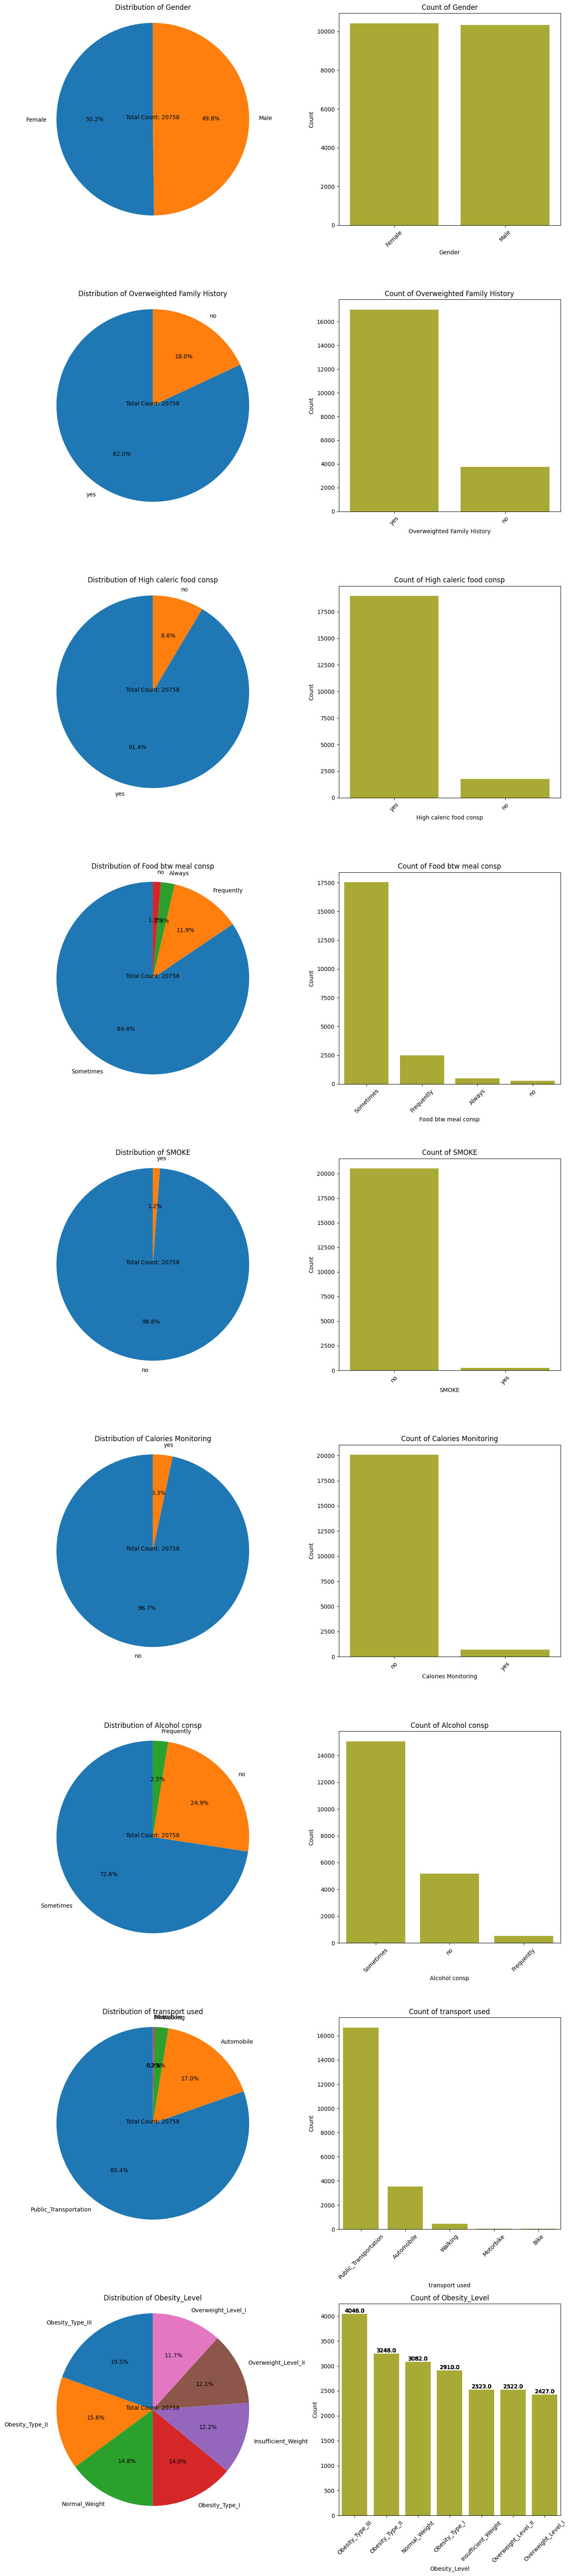

In [ ]:
def plot_data(df):
  categorical_cols = df.select_dtypes(include=['object']).columns

 # Create subplots
  fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(14,7*len(categorical_cols)))

 # Plotting pie chart for each categorical variable in the first

  for i, col in enumerate(categorical_cols):
    ax = axes[i, 0]
    value_counts = df[col].value_counts()
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('')
    ax.axis('equal') # Equal aspect ratio ensures that pie is

    ax.annotate(f'Total Count: {len(df[col])}', xy=(0, 0),
    fontsize=10, ha="center")

 # Plotting bar plot for each categorical variable in the second

    for i, col in enumerate(categorical_cols):
      ax = axes[i, 1]
      value_counts = df[col].value_counts()
      sns.barplot(x=value_counts.index, y=value_counts, ax=ax)
      ax.set_title(f'Count of {col}')
      ax.set_xlabel(f'{col}')
      ax.set_ylabel('Count')
      ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels

    for patch in ax.patches:
      ax.annotate(f'{patch.get_height()}', (patch.get_x() +
      patch.get_width() / 2., patch.get_height()),
      ha='center', va='center', fontsize=10,
      color='black', xytext=(0, 5),
      textcoords='offset points')

  plt.tight_layout()
  plt.show()
# Call the function to plot different types of plots for data_train
plot_data(data_train)

In [ ]:
test_sub.rename(columns=new_column_names, inplace=True)
test_sub.head(5)


,id,Gender,Age,Height,Weight,Overweighted Family History,High caleric food consp,veg consp,main meal consp,Food btw meal consp,SMOKE,Water consp,Calories Monitoring,physical actv,Screentime,Alcohol consp,transport used
0,20758,Male,26,1.848294,120,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21,1.600000,66,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26,1.643355,111,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20,1.553127,103,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26,1.627396,104,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [ ]:
# Encoding of target variables to numerical
keys_dict = {
 'Insufficient_Weight': 0,
 'Normal_Weight': 1,
 'Overweight_Level_I': 2,
 'Overweight_Level_II': 3,
 'Obesity_Type_I': 4,
 'Obesity_Type_II': 5,
 'Obesity_Type_III': 6
}
# Encoding of transport used to numerical
keys_dict_1 = {
 'Automobile': 0,
 'Bike': 1,
 'Motorbike': 2,
 'Public_Transportation': 3,
 'Walking': 4
}
# Encoding of Alcohol consumption to numerical
keys_dict_2 = {
 'Sometimes': 1/3,
 'Frequently': 2/3,
 'Always': 1,
 'no': 0
}
# Encoding of Food between meal consumption to numerical
keys_dict_3 = {
 'Sometimes': 1/3,
 'Frequently': 2/3,
 'Always': 1,
 'no': 0
}
def encode_obesity_level(row):
 return keys_dict.get(row['Obesity_Level'], None)
def encode_transport_used(row):
 return keys_dict_1.get(row['transport used'], None)
def encode_alcohol_consp(row):
 return keys_dict_2.get(row['Alcohol consp'], None)
def encode_food_btw_meal(row):
 return keys_dict_3.get(row['Food btw meal consp'], None)
# Add new columns and apply encoding for train data
data_train['Encdd_Obesity_Level'] = data_train.apply(encode_obesity_level,
axis=1)
data_train['Encdd_transport_used'] =data_train.apply(encode_transport_used, axis=1)
data_train['Encdd_Alcohol_consp'] = data_train.apply(encode_alcohol_consp,
axis=1)
data_train['Encdd_Food_btw_meal'] = data_train.apply(encode_food_btw_meal,
axis=1)
# Add new columns and apply encoding for test data
test_sub['Encdd_transport_used'] = test_sub.apply(encode_transport_used, axis=1)
test_sub['Encdd_Alcohol_consp'] = test_sub.apply(encode_alcohol_consp,
axis=1)
test_sub['Encdd_Food_btw_meal'] = test_sub.apply(encode_food_btw_meal,
axis=1)
data_train.head(5)

,id,Gender,Age,Height,Weight,Overweighted Family History,High caleric food consp,veg consp,main meal consp,Food btw meal consp,...,Calories Monitoring,physical actv,Screentime,Alcohol consp,transport used,Obesity_Level,Encdd_Obesity_Level,Encdd_transport_used,Encdd_Alcohol_consp,Encdd_Food_btw_meal
0,0,Male,24,1.699998,81,yes,yes,2.000000,2.983297,Sometimes,...,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,3,3,0.333333,0.333333
1,1,Female,18,1.560000,57,yes,yes,2.000000,3.000000,Frequently,...,no,1.000000,1.000000,no,Automobile,Normal_Weight,1,0,0.000000,0.666667
2,2,Female,18,1.711460,50,yes,yes,1.880534,1.411685,Sometimes,...,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,0,3,0.000000,0.333333
3,3,Female,20,1.710730,131,yes,yes,3.000000,3.000000,Sometimes,...,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,6,3,0.333333,0.333333
4,4,Male,31,1.914186,93,yes,yes,2.679664,1.971472,Sometimes,...,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,3,3,0.333333,0.333333


In [ ]:
gender_mapping = {'Male': 1, 'Female': 0}
family_history_mapping = {'yes': 1, 'no': 0}
high_caloric_mapping = {'yes': 1, 'no': 0}
smoke_mapping = {'yes': 1, 'no': 0}
calories_monitoring_mapping = {'yes': 1, 'no': 0}
# Define functions to apply mappings and create new encoded columns
def encode_gender(row):
 return gender_mapping.get(row['Gender'], None)
def encode_family_history(row):
 return family_history_mapping.get(row['Overweighted Family History'], None)
def encode_high_caloric(row):
 return high_caloric_mapping.get(row['High caleric food consp'],
None)
def encode_smoke(row):
 return smoke_mapping.get(row['SMOKE'], None)
def encode_calories_monitoring(row):
  return calories_monitoring_mapping.get(row['Calories Monitoring'],
None)
# Apply functions to create new encoded columns for train data
data_train['Encoded_Gender'] = data_train.apply(encode_gender, axis=1)
data_train['Encoded_Family_History'] =data_train.apply(encode_family_history, axis=1)
data_train['Encoded_High_Caloric'] = data_train.apply(encode_high_caloric,axis=1)
data_train['Encoded_Smoke'] = data_train.apply(encode_smoke, axis=1)
data_train['Encoded_Calories_Monitoring'] =data_train.apply(encode_calories_monitoring, axis=1)
# Apply functions to create new encoded columns for train data
test_sub['Encoded_Gender'] = test_sub.apply(encode_gender, axis=1)
test_sub['Encoded_Family_History'] =test_sub.apply(encode_family_history, axis=1)
test_sub['Encoded_High_Caloric'] = test_sub.apply(encode_high_caloric,
axis=1)
test_sub['Encoded_Smoke'] = test_sub.apply(encode_smoke, axis=1)
test_sub['Encoded_Calories_Monitoring'] =test_sub.apply(encode_calories_monitoring, axis=1)

In [ ]:
data_train['BMI'] = data_train['Weight'] / (data_train['Height'] ** 2)
test_sub['BMI'] = test_sub['Weight'] / (test_sub['Height'] ** 2)

In [ ]:
data_train['Meal'] = data_train['main meal consp'] +data_train['Encdd_Food_btw_meal']
test_sub['Meal'] = test_sub['main meal consp'] +test_sub['Encdd_Food_btw_meal']

In [ ]:
data_train['Activity'] = data_train['physical actv'] *data_train['Screentime']
test_sub['Activity'] = test_sub['physical actv'] *test_sub['Screentime']

In [ ]:
data_train['IsYoung'] = data_train['Age'].apply(lambda x: x < 25)
data_train['IsAging'] = data_train['Age'].apply(lambda x: 25 <= x < 40)
test_sub['IsYoung'] = test_sub['Age'].apply(lambda x: x < 25)
test_sub['IsAging'] = test_sub['Age'].apply(lambda x: 25 <= x < 40)
data_train.head(5)


,id,Gender,Age,Height,Weight,Overweighted Family History,High caleric food consp,veg consp,main meal consp,Food btw meal consp,...,Encoded_Gender,Encoded_Family_History,Encoded_High_Caloric,Encoded_Smoke,Encoded_Calories_Monitoring,BMI,Meal,Activity,IsYoung,IsAging
0,0,Male,24,1.699998,81,yes,yes,2.000000,2.983297,Sometimes,...,1,1,1,0,0,28.027748,3.316630,0.000000,True,False
1,1,Female,18,1.560000,57,yes,yes,2.000000,3.000000,Frequently,...,0,1,1,0,0,23.422091,3.666667,1.000000,True,False
2,2,Female,18,1.711460,50,yes,yes,1.880534,1.411685,Sometimes,...,0,1,1,0,0,17.070117,1.745018,1.449399,True,False
3,3,Female,20,1.710730,131,yes,yes,3.000000,3.000000,Sometimes,...,0,1,1,0,0,44.761884,3.333333,1.145225,True,False
4,4,Male,31,1.914186,93,yes,yes,2.679664,1.971472,Sometimes,...,1,1,1,0,0,25.381348,2.304805,1.833602,False,True


In [ ]:
test_sub.head(5)
data_train.head(1)

,id,Gender,Age,Height,Weight,Overweighted Family History,High caleric food consp,veg consp,main meal consp,Food btw meal consp,...,Encoded_Gender,Encoded_Family_History,Encoded_High_Caloric,Encoded_Smoke,Encoded_Calories_Monitoring,BMI,Meal,Activity,IsYoung,IsAging
0,0,Male,24,1.699998,81,yes,yes,2.0,2.983297,Sometimes,...,1,1,1,0,0,28.027748,3.31663,0.0,True,False


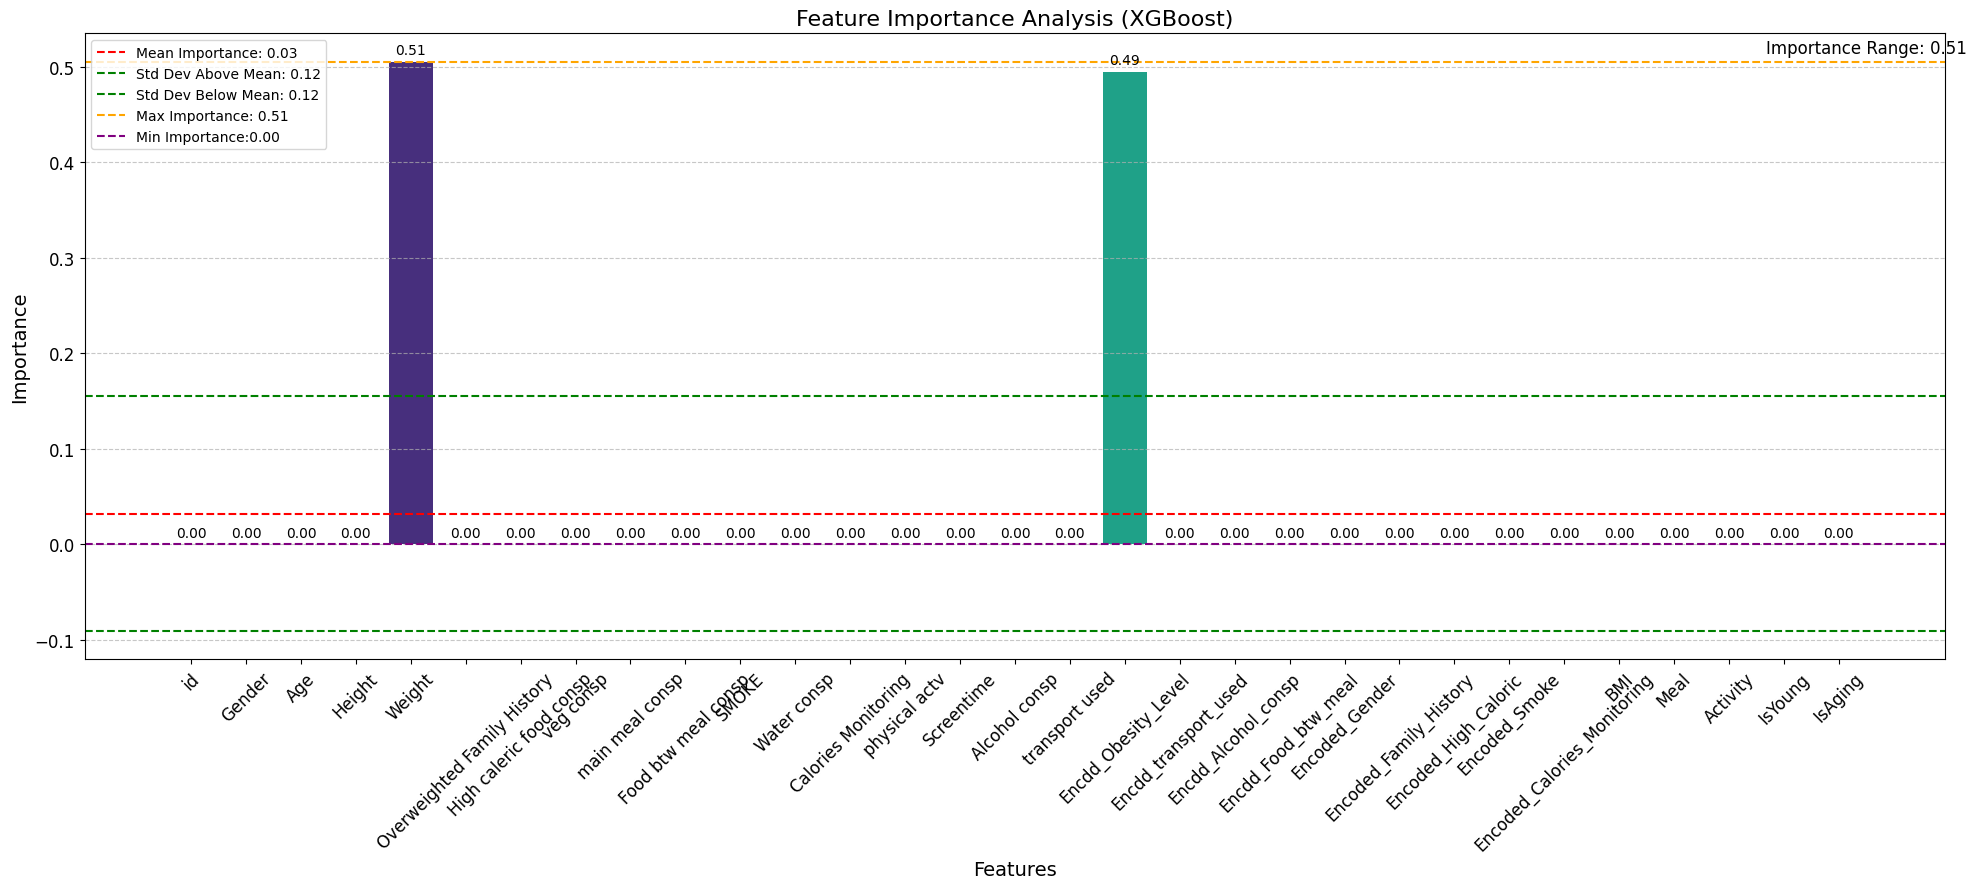

In [ ]:
#XGBoost
from sklearn.preprocessing import LabelEncoder # For encoding
# Assuming df_train contains your dataset
# Define X (features) and y (target variable)
X = data_train.drop(columns=['Obesity_Level'])
y = data_train['Obesity_Level']
# Encode target variable into numerical labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
# Encode categorical features
encoder = LabelEncoder()
X_encoded = X.copy()
for col in X_encoded.columns:
 if X_encoded[col].dtype == 'object': X_encoded[col] = encoder.fit_transform(X_encoded[col])
# Initialize the XGBoost classifier
model_xgb = xgb.XGBClassifier()
# Train the model
model_xgb.fit(X_encoded, y_encoded)
# Get feature importances
feature_importances_xgb = model_xgb.feature_importances_
# Calculate statistical information
mean_importance = np.mean(feature_importances_xgb)
std_importance = np.std(feature_importances_xgb)
max_importance = np.max(feature_importances_xgb)
importance_range = max_importance - np.min(feature_importances_xgb)
# Count the occurrences of each feature
feature_counts = X_encoded.apply(lambda x:x.value_counts()).fillna(0).astype(int)
# Visualize feature importances
plt.figure(figsize=(20, 9))
colors = plt.cm.viridis(np.linspace(0, 1, len(X_encoded.columns)))
bars = plt.bar(X_encoded.columns, feature_importances_xgb,
color=colors) # Change color
plt.xlabel('Features', fontsize=14) # Increase font size
plt.ylabel('Importance', fontsize=14) # Increase font size
plt.title('Feature Importance Analysis (XGBoost)', fontsize=16) #

plt.xticks(rotation=45, fontsize=12) # Rotate x-axis labels and

plt.yticks(fontsize=12) # Increase font size for y-axis ticks
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add grid lines for
# Add statistical information
plt.axhline(mean_importance, color='red', linestyle='--', label=f'Mean Importance: {mean_importance:.2f}')
plt.axhline(mean_importance + std_importance, color='green',
linestyle='--', label=f'Std Dev Above Mean: {std_importance:.2f}')
plt.axhline(mean_importance - std_importance, color='green',
linestyle='--', label=f'Std Dev Below Mean: {std_importance:.2f}')
plt.axhline(max_importance, color='orange', linestyle='--',
label=f'Max Importance: {max_importance:.2f}')
plt.axhline(np.min(feature_importances_xgb), color='purple',
linestyle='--', label=f'Min Importance:{np.min(feature_importances_xgb):.2f}')
plt.text(len(X_encoded.columns)-0.5, max_importance + 0.005,
f'Importance Range: {importance_range:.2f}', ha='center', va='bottom',
fontsize=12, color='black')
# Add feature importance values above each bar
for i, importance in enumerate(feature_importances_xgb):
 plt.text(i, importance + 0.005, f'{importance:.2f}', ha='center',va='bottom', fontsize=10, color='black')
plt.legend()
plt.tight_layout() # Adjust layout to prevent overlapping labels
plt.show()

In [ ]:
data_train.describe()

,id,Age,Height,Weight,veg consp,main meal consp,Water consp,physical actv,Screentime,Encdd_Obesity_Level,...,Encdd_Alcohol_consp,Encdd_Food_btw_meal,Encoded_Gender,Encoded_Family_History,Encoded_High_Caloric,Encoded_Smoke,Encoded_Calories_Monitoring,BMI,Meal,Activity
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,...,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.565950,1.700245,87.572165,2.445908,2.761332,2.029418,0.981747,0.616756,3.259370,...,0.258920,0.383900,0.497929,0.819636,0.914443,0.011803,0.033096,30.132951,3.145232,0.616205
std,5992.46278,5.630841,0.087312,26.204825,0.533218,0.705375,0.608467,0.838302,0.602113,2.063472,...,0.157897,0.149679,0.500008,0.384500,0.279716,0.108000,0.178891,8.269444,0.734134,0.990915
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.770354,1.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000,1.000000,...,0.333333,0.333333,0.000000,1.000000,1.000000,0.000000,0.000000,24.034610,3.333333,0.000000
50%,10378.50000,22.000000,1.700000,84.000000,2.393837,3.000000,2.000000,1.000000,0.573887,3.000000,...,0.333333,0.333333,0.000000,1.000000,1.000000,0.000000,0.000000,29.384757,3.333333,0.000000
75%,15567.75000,26.000000,1.762887,111.000000,3.000000,3.000000,2.549617,1.587406,1.000000,5.000000,...,0.333333,0.333333,1.000000,1.000000,1.000000,0.000000,0.000000,36.863295,3.333333,1.000000
max,20757.00000,61.000000,1.975663,165.000000,3.000000,4.000000,3.000000,3.000000,2.000000,6.000000,...,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,54.978909,5.000000,6.000000


In [ ]:
print(data_train.columns)


Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'Overweighted Family History', 'High caleric food consp', 'veg consp',
       'main meal consp', 'Food btw meal consp', 'SMOKE', 'Water consp',
       'Calories Monitoring', 'physical actv', 'Screentime', 'Alcohol consp',
       'transport used', 'Obesity_Level', 'Encdd_Obesity_Level',
       'Encdd_transport_used', 'Encdd_Alcohol_consp', 'Encdd_Food_btw_meal',
       'Encoded_Gender', 'Encoded_Family_History', 'Encoded_High_Caloric',
       'Encoded_Smoke', 'Encoded_Calories_Monitoring', 'BMI', 'Meal',
       'Activity', 'IsYoung', 'IsAging'],
      dtype='object')


In [ ]:
 X = data_train.drop(['Obesity_Level','Encdd_Obesity_Level'], axis=1)
 y = data_train['Obesity_Level']
 # Encode target variable into numerical labels
 encoder = LabelEncoder()
 y_encoded = encoder.fit_transform(y)
 # Encode categorical features
 X_encoded = X.copy()
 for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        encoder = LabelEncoder()
        X_encoded[col] = encoder.fit_transform(X_encoded[col])
 # Train-test split
 X_train, X_test, y_train, y_test = train_test_split(X_encoded,
y_encoded, test_size=0.2, random_state=42)
 # XGBClassifier Model
 xgb_model = XGBClassifier(
    max_depth=5,
    learning_rate=0.01,
    n_estimators=1000,
    min_child_weight=1,
    gamma=1,
    subsample=0.95,
    colsample_bytree=0.95,
    reg_lambda=0.5,
    reg_alpha=2,
    random_state=42,
    enable_categorical=True  # Enable categorical support
 )
 xgb_model.fit(X_train, y_train)
 # Generate predictions
 xgb_predictions = xgb_model.predict_proba(X_test)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


xgb_predictions_proba = xgb_model.predict_proba(X_test)
xgb_predictions = xgb_predictions_proba.argmax(axis=1)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions, average='weighted')
xgb_recall = recall_score(y_test, xgb_predictions, average='weighted')
xgb_f1 = f1_score(y_test, xgb_predictions, average='weighted')
xgb_confusion_matrix = confusion_matrix(y_test, xgb_predictions)

In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
 iterations=1000,
 learning_rate=0.01,
 depth=6,
 random_seed=42,
 loss_function='MultiClass',
 eval_metric='Accuracy',
 verbose=False
)
catboost_model.fit(X_train, y_train, verbose=False)

In [ ]:

catboost_predictions_proba = catboost_model.predict_proba(X_test)
catboost_predictions = catboost_predictions_proba.argmax(axis=1)
catboost_accuracy = accuracy_score(y_test, catboost_predictions)
catboost_precision = precision_score(y_test, catboost_predictions,
average='weighted')
catboost_recall = recall_score(y_test, catboost_predictions,average='weighted')
catboost_f1 = f1_score(y_test, catboost_predictions,average='weighted')
catboost_confusion_matrix = confusion_matrix(y_test,catboost_predictions)
print(f"Accuracy: {catboost_accuracy:.4f}")
print(f"Precision (weighted): {catboost_precision:.4f}")
print(f"Recall (weighted): { catboost_recall :.4f}")
print(f"F1 Score (weighted): {catboost_f1:.4f}")
print("Confusion Matrix:")
print(catboost_confusion_matrix)

Accuracy: 0.8926
Precision (weighted): 0.8925
Recall (weighted): 0.8926
F1 Score (weighted): 0.8925
Confusion Matrix:
[[487  34   0   0   0   2   1]
 [ 35 544   0   0   0  46   1]
 [  2   2 465  21   2  11  40]
 [  0   0  15 637   2   0   3]
 [  0   0   1   1 802   0   0]
 [  1  49   8   0   0 367  59]
 [  0   8  38   2   0  62 404]]


In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,     # Number of trees in the forest
    max_depth=6,          # Max depth of the tree
    random_state=42       # For reproducibility
)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict probabilities and final class labels
rf_predictions_proba = rf_model.predict_proba(X_test)
rf_predictions = rf_predictions_proba.argmax(axis=1)

# Evaluate performance
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, average='weighted')
rf_recall = recall_score(y_test, rf_predictions, average='weighted')
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Print results
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision (weighted): {rf_precision:.4f}")
print(f"Recall (weighted): {rf_recall:.4f}")
print(f"F1 Score (weighted): {rf_f1:.4f}")
print("Confusion Matrix:")
print(rf_conf_matrix)


Accuracy: 0.8793
Precision (weighted): 0.8801
Recall (weighted): 0.8793
F1 Score (weighted): 0.8780
Confusion Matrix:
[[478  43   0   0   0   2   1]
 [ 26 568   0   0   0  24   8]
 [  1   4 455  31   1  11  40]
 [  0   0  16 637   1   0   3]
 [  0   1   0   1 802   0   0]
 [  1  73   9   0   0 313  88]
 [  0  23  51   4   0  38 398]]


In [ ]:
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision (weighted): {xgb_precision:.4f}")
print(f"Recall (weighted): {xgb_recall:.4f}")
print(f"F1 Score (weighted): {xgb_f1:.4f}")
print("Confusion Matrix:")
print(xgb_confusion_matrix)

Accuracy: 0.9041
Precision (weighted): 0.9042
Recall (weighted): 0.9041
F1 Score (weighted): 0.9041
Confusion Matrix:
[[493  28   0   0   0   2   1]
 [ 28 559   0   0   0  33   6]
 [  2   0 475  11   1  15  39]
 [  0   0  11 642   2   0   2]
 [  0   0   0   1 802   1   0]
 [  1  47   7   0   0 372  57]
 [  0  10  33   4   0  56 411]]


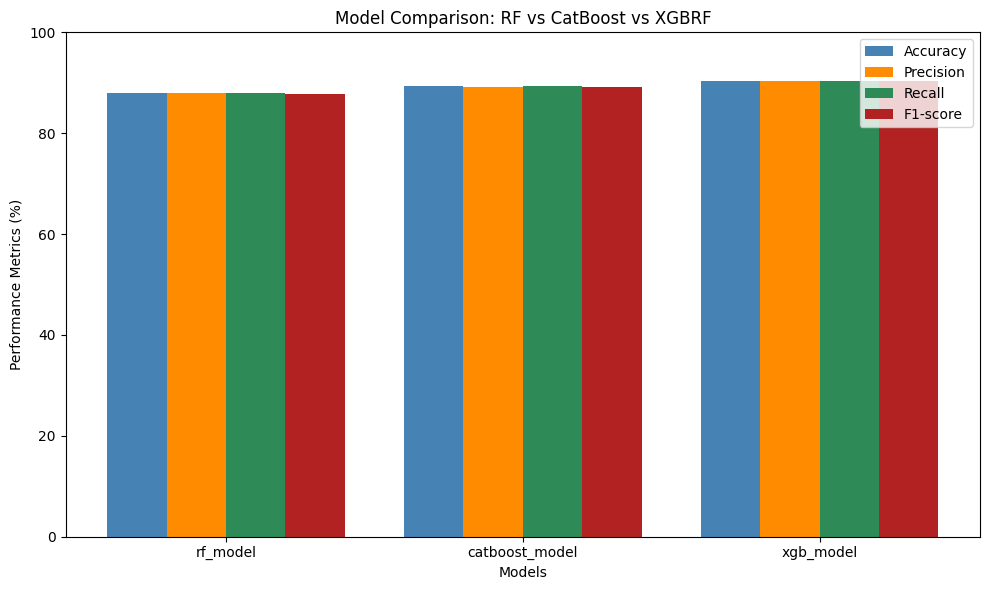

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List models in desired order
models = ['rf_model', 'catboost_model', 'xgb_model']

# Replace these with your actual computed metrics
accuracy = [rf_accuracy * 100, catboost_accuracy * 100, xgb_accuracy * 100]
precision = [rf_precision * 100, catboost_precision * 100, xgb_precision * 100]
recall = [rf_recall * 100, catboost_recall * 100, xgb_recall * 100]
f1 = [rf_f1 * 100, catboost_f1 * 100, xgb_f1 * 100]

x = np.arange(len(models))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5 * width, accuracy, width, label='Accuracy', color='steelblue')
ax.bar(x - 0.5 * width, precision, width, label='Precision', color='darkorange')
ax.bar(x + 0.5 * width, recall, width, label='Recall', color='seagreen')
ax.bar(x + 1.5 * width, f1, width, label='F1-score', color='firebrick')

# Labels and formatting
ax.set_ylabel('Performance Metrics (%)')
ax.set_xlabel('Models')
ax.set_title('Model Comparison: RF vs CatBoost vs XGBRF')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


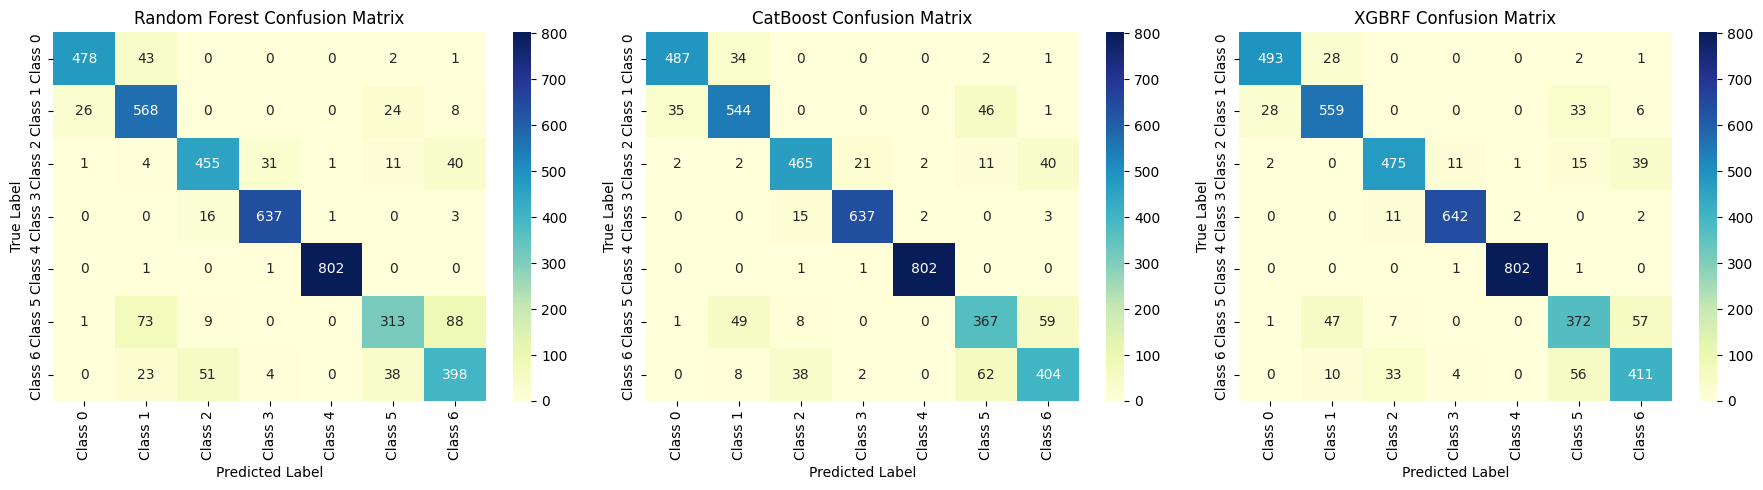

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace these with your actual confusion matrices
# Format: confusion_matrix = np.array([...])
rf_cm = rf_conf_matrix
catboost_cm = catboost_confusion_matrix
xgb_cm = xgb_confusion_matrix

model_names = ['Random Forest', 'CatBoost', 'XGBRF']
conf_matrices = [rf_cm, catboost_cm, xgb_cm]

# Optional: define class labels
labels = [f'Class {i}' for i in range(rf_cm.shape[0])]

# Plot all three confusion matrices as heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, cm, name in zip(axes, conf_matrices, model_names):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()


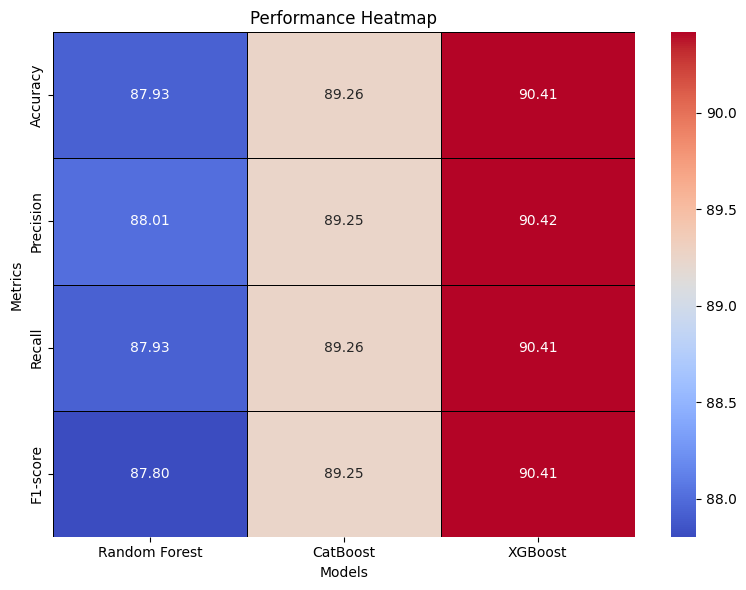

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


data = {
    'Random Forest': [rf_accuracy*100, rf_precision*100, rf_recall*100, rf_f1*100],
    'CatBoost': [catboost_accuracy*100, catboost_precision*100, catboost_recall*100, catboost_f1*100],
    'XGBoost': [xgb_accuracy*100, xgb_precision*100, xgb_recall*100, xgb_f1*100]
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
df = pd.DataFrame(data, index=metrics)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5, linecolor='black')

plt.title("Performance Heatmap")
plt.xlabel("Models")
plt.ylabel("Metrics")
plt.tight_layout()
plt.show()


In [ ]:
!pip install streamlit pyngrok --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Load training data
data_train = pd.read_csv('/content/sample_data/train.csv')  # Use your uploaded file

# Prepare data
X = data_train.drop(['NObeyesdad','id'], axis=1)
y = data_train['NObeyesdad']

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Encode categorical features
X_encoded = X.copy()
feature_encoders = {}
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])
        feature_encoders[col] = le

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBClassifier(
    max_depth=7,
    learning_rate=0.1,
    n_estimators=1500,
    min_child_weight=1,
    gamma=1,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=0.5,
    reg_alpha=2,
    random_state=42,
    enable_categorical=True  # Enable categorical support
 )
model.fit(X_train, y_train)

# Save model and encoders
joblib.dump(model, "xgb_model.pkl")
joblib.dump(target_encoder, "target_encoder.pkl")
joblib.dump(feature_encoders, "feature_encoders.pkl")


['feature_encoders.pkl']

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load model and encoders
model = joblib.load("xgb_model.pkl")
target_encoder = joblib.load("target_encoder.pkl")
feature_encoders = joblib.load("feature_encoders.pkl")

# App Title and Logo
st.set_page_config(page_title="Obesity Risk Predictor", layout="centered")
#st.image("logo.png", width=100)  # Optional: add your logo file
st.title("🏥 Obesity Risk Prediction Web-Application")
st.markdown("### 🧾 Please fill in your health and lifestyle information")

# Input Form Using Columns and Expanders
with st.form("obesity_form"):
    # Demographic Section
    st.markdown("#### 🧍 Demographics")
    col1, col2 = st.columns(2)
    with col1:
        gender = st.selectbox("Gender", ["Male", "Female"])
        age = st.slider("Age", 10, 100, 25)
    with col2:
        height = st.number_input("Height (m)", 1.0, 2.5, 1.7)
        weight = st.number_input("Weight (kg)", 30.0, 200.0, 70.0)

    # Family History and Habits
    with st.expander("👨‍👩‍👧 Family & Habits"):
        family_history = st.selectbox("Do you have a family History of Overweight", ["yes", "no"])
        smoke = st.selectbox("Do you smoke?", ["yes", "no"])
        scc = st.selectbox("Do you monitor calorie consumption?", ["yes", "no"])

    # Eating Habits
    with st.expander("🍽️ Eating Habits"):
        favc = st.selectbox("Do you eat high-caloric food frequently ?", ["yes", "no"])
        fcvc = st.slider("Vegetable consumption frequency", 1.0, 3.0, 2.0)
        ncp = st.slider("Number of main meals in a day ", 1, 4, 3)
        caec = st.selectbox("How often do you eat between meals", ["no", "Sometimes", "Frequently", "always"])

    # Lifestyle
    with st.expander("💪 Lifestyle"):
        ch2o = st.slider("Daily water intake(in litres))", 1.0, 3.0, 2.0)
        faf = st.slider("Physical activity frequency (hours per week)", 0.0, 4.0, 1.0)
        tue = st.slider("Time using technology devices (in a day)", 0.0, 8.0, 1.0)
        calc = st.selectbox("Alcohol consumption)", ["no", "Sometimes", "Frequently", "always"])
        mtrans = st.selectbox("Mode of transportation", ["Automobile", "Motorbike", "Bike", "Public_Transportation", "Walking"])

    submitted = st.form_submit_button("🚀 Predict")

if submitted:
    # Create DataFrame
    input_df = pd.DataFrame([{
        "Gender": gender,
        "Age": age,
        "Height": height,
        "Weight": weight,
        "family_history_with_overweight": family_history,
        "FAVC": favc,
        "FCVC": fcvc,
        "NCP": ncp,
        "CAEC": caec,
        "SMOKE": smoke,
        "CH2O": ch2o,
        "SCC": scc,
        "FAF": faf,
        "TUE": tue,
        "CALC": calc,
        "MTRANS": mtrans
    }])

    # Encode categorical features
    for col in input_df.columns:
        if col in feature_encoders:
            try:
                input_df[col] = feature_encoders[col].transform(input_df[col])
            except Exception as e:
                st.warning(f"Encoding issue for '{col}': {e}")

    # Display input summary

    #st.dataframe(input_df)

    # Prediction with spinner
    with st.spinner("Predicting obesity level..."):
        prediction = model.predict(input_df)[0]
        pred_label = target_encoder.inverse_transform([prediction])[0]

    # Result styling
    st.markdown("### 🧠 Prediction Result:")
    if "Obesity" in pred_label:
        st.error(f"⚠️ Predicted Obesity Level: **{pred_label}**, ")
    elif "Overweight" in pred_label:
        st.warning(f"🔶 Predicted Obesity Level: **{pred_label}**")
    elif "Insufficient" in pred_label:
        st.success(f" ⚠️Predicted Obesity Level: **{pred_label}**")
    else:

        st.success(f"✅ Predicted Obesity Level: **{pred_label}**")



Writing app.py


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load model and encoders
model = joblib.load("xgb_model.pkl")
target_encoder = joblib.load("target_encoder.pkl")
feature_encoders = joblib.load("feature_encoders.pkl")

# Default fallback values for unseen categories
default_values = {
    "CALC": "Sometimes",
    "CAEC": "Sometimes",
    "MTRANS": "Public_Transportation",
    "Gender": "Female",
    "family_history_with_overweight": "no",
    "FAVC": "no",
    "SMOKE": "no",
    "SCC": "no"
}

# App Title and Layout
st.set_page_config(page_title="Obesity Risk Predictor", layout="centered")
st.title("🏥 Obesity Risk Prediction Web-Application")
st.markdown("### 🧾 Please fill in your health and lifestyle information")

# Input Form
with st.form("obesity_form"):
    st.markdown("#### 🧍 Demographics")
    col1, col2 = st.columns(2)
    with col1:
        gender = st.selectbox("Gender", ["Male", "Female"])
        age = st.slider("Age", 10, 100, 25)
    with col2:
        height = st.number_input("Height (m)", 1.0, 2.5, 1.7)
        weight = st.number_input("Weight (kg)", 30.0, 200.0, 70.0)

    with st.expander("👨‍👩‍👧 Family & Habits"):
        family_history = st.selectbox("Do you have a family History of Overweight", ["yes", "no"])
        smoke = st.selectbox("Do you smoke?", ["yes", "no"])
        scc = st.selectbox("Do you monitor calorie consumption?", ["yes", "no"])

    with st.expander("🍽️ Eating Habits"):
        favc = st.selectbox("Do you eat high-caloric food frequently ?", ["yes", "no"])
        fcvc = st.slider("Vegetable consumption frequency", 1.0, 3.0, 2.0)
        ncp = st.slider("Number of main meals in a day ", 1, 4, 3)
        caec = st.selectbox("How often do you eat between meals", ["no", "Sometimes", "Frequently", "always"])

    with st.expander("💪 Lifestyle"):
        ch2o = st.slider("Daily water intake (in litres)", 1.0, 3.0, 2.0)
        faf = st.slider("Physical activity frequency (hours per week)", 0.0, 4.0, 1.0)
        tue = st.slider("Time using technology devices (in a day)", 0.0, 8.0, 1.0)
        calc = st.selectbox("Alcohol consumption", ["no", "Sometimes", "Frequently", "always"])
        mtrans = st.selectbox("Mode of transportation", ["Automobile", "Motorbike", "Bike", "Public_Transportation", "Walking"])

    submitted = st.form_submit_button("🚀 Predict")

if submitted:
    # Assemble input into DataFrame
    input_df = pd.DataFrame([{
        "Gender": gender,
        "Age": age,
        "Height": height,
        "Weight": weight,
        "family_history_with_overweight": family_history,
        "FAVC": favc,
        "FCVC": fcvc,
        "NCP": ncp,
        "CAEC": caec,
        "SMOKE": smoke,
        "CH2O": ch2o,
        "SCC": scc,
        "FAF": faf,
        "TUE": tue,
        "CALC": calc,
        "MTRANS": mtrans
    }])

    # Apply encoders with default substitution
    for col in input_df.columns:
        if col in feature_encoders:
            encoder = feature_encoders[col]
            val = input_df[col].iloc[0]
            if val not in encoder.classes_:
                fallback = default_values.get(col, encoder.classes_[0])
                input_df[col] = [fallback]
            input_df[col] = encoder.transform(input_df[col])

    # Prediction
    with st.spinner("Predicting obesity level..."):
        prediction = model.predict(input_df)[0]
        pred_label = target_encoder.inverse_transform([prediction])[0]

    # Show result
    st.markdown("### 🧠 Prediction Result:")
    if "Obesity" in pred_label:
        st.error(f"⚠️ Predicted Obesity Level: **{pred_label}**")
    elif "Overweight" in pred_label:
        st.warning(f"🔶 Predicted Obesity Level: **{pred_label}**")
    elif "Insufficient" in pred_label:
        st.success(f"⚠️ Predicted Obesity Level: **{pred_label}**")
    else:
        st.success(f"✅ Predicted Obesity Level: **{pred_label}**")



Overwriting app.py


In [ ]:
# Create the directory for the Streamlit config file
!mkdir -p .streamlit

# Write the custom cute theme configuration to config.toml
with open('.streamlit/config.toml', 'w') as f:
    f.write("""
[theme]
base="light"
primaryColor="#FF69B4"            # Hot pink (buttons, sliders)
backgroundColor="#FFF0F5"         # Lavender blush (main background)
secondaryBackgroundColor="#FFE4E1" # Misty rose (sidebar/cards)
textColor="#800080"              # Deep purple (text)
font="sans serif"                 # Playful font
""")




In [ ]:
!ngrok config add-authtoken 2vtjyYTVC6ePnWcCswblHGbzZy4_6NAjTCqa6FrKDVdji6L4R


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [44]:
from pyngrok import ngrok

# Run Streamlit in background
!streamlit run app.py &>/dev/null &

# Connect ngrok to the Streamlit app running on port 8501
public_url = ngrok.connect(addr="8501", proto="http")
print(f"🌐 Open your Streamlit app here: {public_url}")




🌐 Open your Streamlit app here: NgrokTunnel: "https://82ab159456dc.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
from pyngrok import ngrok

ngrok.kill()
